# Speed dating data-set
## Discrimination-aware classification
#### <i>Abdel K. Bokharouss, Bart van Helvert, Joris Rombouts & Remco Surtel</i>   -   December 2017

<font color="darkred"><b><i>Important note: a concrete goal of this assignment is, among other things, to give an extensive and qualitative comparison between a model which includes sensitive attributes and a model which excludes these sensitive attributes. Whether or not attributes are considered to be sensitive is subjective, and any decisions should, therefore, be supported by well-grounded arguments.</i></b>
<br>
<b><i>This brings us to our next important point: This assignment was discussed during the instruction of Wednesday (29-11). The conclusion was made that the models of our first assignment used no significant amount of sensitive attributes (this was no requirement of the first assignment) to facilitate a qualitve comparison. In consultation with the instructors present during that instruction, the choice is made to re-make the same model which was used in assignment 1, but with more sensitive attributes. This will facilitate a better comparison with the discrimination-aware model which uses no sensitive attributes</i></b></font>

### <font color="green">imports, preparation and configuration</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
import imageio
%matplotlib inline

In [2]:
# imports needed for the visualization and exportation of visualizations
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
import io
from scipy import misc

In [3]:
from IPython.core.display import HTML # markdown cell styling and enabling/disabling warning messages
HTML("""
<style>
div.text_cell_render h1 {
font-size: 1.6em;
line-height:1.2em;
}

div.text_cell_render h2 { 
margin-bottom: -0.4em;
}

div.text_cell_render { 
font-size:1.2em;
line-height:1.2em;
font-weight:500;
}

div.text_cell_render p, li {
color:Navy;
}

</style>

<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.
""") 

In [4]:
np.random.seed(88) # seed the generator

The previous model used the following attributes:
* <b>order</b>
* <b>field</b>
* <b>imprace</b> and <b>imprelig</b>
* <b>goal</b>, <b>date</b> and <b>go_out</b>

And in 1.3 the following attributes were "engineered" from existing attributes:
* <b>age_diff</b>: The absolute difference between the subject's age and partner's age
* <b>attr_o</b>: ating by partner the night of the event, for all six attributes (attr, sinc, intel, fun, amb, and shar)
* <b>race_equals</b>:  boolean value, which is True if the race of the partner is the same as the race of the participant, and False otherwise.
* <b>goal_equals</b>: boolean value, which is True if the goal of the partner is the same as the goal of the participant, and False otherwise.

<font color="darkred">The attributes <b>imprace</b>, <b>imprelig</b>, <b>age_diff</b> and <b>race_equals</b> are considered to be sensitive attributes</font>

<font color="darkred">The choice was made to feed the model one more sensitive attribute: <b>race</b>. Other attributes that were considered sensitive is the <b>income</b> attribute. This attribute has, however, a lot of missing values. Which is why the choice was made to not include it in the model. In addition to adding one sensitive attribute to the model the goal of re-making the model is to decrease the <b>height</b> of the decision tree. The height of the decision trees in the first assignment was chosen to be eight. A tree with a lower height would ease the visualization evaluation process. The height is going to be decreased in steps while checking the performance of the models. The goal is to find the right trade-off between the height and the performance of the model.</font>

### <font color="green">Gender models with sensitive attributes</font>

In [5]:
dates = pd.read_csv("speed_dating_assignment.csv")
dates.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


The next few cells are for preprocessing purposes (filtering, construction of new attributes etc.)

In [6]:
dates_new = dates.copy()
dates_new = dates_new.filter(items = ['iid', 'age', 'race', 'goal'])
dates_new.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
dates_new = dates_new.drop_duplicates()
dates_new_merge = pd.merge(dates, dates_new, on=['pid'], how = 'left')
dates = dates_new_merge.copy()

In [7]:
dates = dates[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner', 'dec']]

In [8]:
dates.age.fillna(dates.age.median(), inplace = True)
dates = dates.dropna().reset_index(drop = True)

#### <font color="green">Calculating new features</font>

<font color="red"><b><i>Explanations have been left out in this document. If one is interested in the explanation of the code and/or results. Please see consult our first assignment</i></b>

In [9]:
dates['attr_o'] = dates['attr'] + dates['sinc'] + dates['intel'] + dates['fun'] + dates['amb'] + dates['shar']
dates = dates.drop(['attr', 'sinc', 'intel', 'fun', 'shar', 'amb'], axis = 1)

In [10]:
dates['age_diff'] = abs(dates['age'] - dates['age_o'])

In [11]:
dates['race_equals'] = (dates['race'] == dates['race_partner'])

In [12]:
dates['goal_equals'] = dates.apply(lambda r: r.goal == r.goal_partner, axis = 1)

In [13]:
dates = dates[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace',  'imprelig', 'attr_o', 'race','age_diff', 'goal_equals', 'dec']]
dates.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,attr_o,race,age_diff,goal_equals,dec
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,40.0,4.0,6.0,False,1
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,41.0,4.0,1.0,False,1
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,42.0,4.0,1.0,True,1
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,42.0,4.0,2.0,True,1
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,37.0,4.0,3.0,False,1


In [14]:
male_subjects = dates[dates.gender == 1]
female_subjects = dates[dates.gender == 0]
male_subjects = male_subjects.drop('gender', axis = 1) # do not need this attribute
female_subjects = female_subjects.drop('gender', axis = 1) # do not need this attribute
male_subjects.shape, female_subjects.shape

((3455, 13), (3384, 13))

In [15]:
male_subjects_shuffle = male_subjects.sample(frac=1).reset_index(drop=True) # shuffle rows
female_subjects_shuffle = female_subjects.sample(frac=1).reset_index(drop=True)

In [16]:
male_x_data = male_subjects_shuffle.drop('dec', axis = 1) # dec is target attribute
female_x_data = female_subjects_shuffle.drop('dec', axis = 1)
male_labels = male_subjects_shuffle['dec']
female_labels = female_subjects_shuffle['dec']

In [17]:
male_x_train, male_x_test, male_y_train, male_y_test = train_test_split(male_x_data, male_labels, test_size = 0.2)
female_x_train, female_x_test, female_y_train, female_y_test = train_test_split(female_x_data, female_labels, test_size = 0.2)

In [18]:
dec_tree_male = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_female = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
# build decision tree classifiers from the training sets
dec_tree_male.fit(male_x_train, male_y_train)
dec_tree_female.fit(female_x_train, female_y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [19]:
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = imageio.imread(path)
    plt.imshow(i)

In [20]:
male_col_names = dec_tree_male.classes_
male_feature_names = male_subjects.columns[0:(male_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_male, "male_decision_tree_sens.png", male_col_names, male_feature_names)

ImportError: DLL load failed: Kan opgegeven module niet vinden.

In [ ]:
female_col_names = dec_tree_female.classes_
female_feature_names = female_subjects.columns[0:(female_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_female, "female_decision_tree_sens.png", female_col_names, female_feature_names)

### <font color="green">Evaluating the performance of the gender models</font>

<font color="red"><b><i>Explanations have been left out in this document. If one is interested in the explanation of the code and/or results. Please see consult our first assignment</i></b>

In [ ]:
pred_male = dec_tree_male.predict(male_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(male_y_test, pred_male))

In [ ]:
pred_female = dec_tree_female.predict(female_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(female_y_test, pred_female))

In [ ]:
print(metrics.classification_report(male_y_test, pred_male))

In [ ]:
print('percentage "dec = 0" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 0].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 1].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")

In [ ]:
print(metrics.classification_report(female_y_test, pred_female))

In [ ]:
print('percentage "dec = 0" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 0].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 1].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")

### <font color="green">Unisex model with sensitive attributes</font>

In [21]:
unisex = pd.read_csv("speed_dating_assignment.csv")

In [22]:
unisex_o = unisex.copy()
unisex_o = unisex_o.filter(items=['iid', 'age', 'race', 'goal'])
unisex_o.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
unisex_o = unisex_o.drop_duplicates()

unisex_new = pd.merge(unisex, unisex_o, on=['pid'], how = 'left')
unisex = unisex_new.copy()

In [23]:
unisex = unisex[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner']]
unisex.age.fillna(unisex.age.median(), inplace = True)
unisex = unisex.dropna().reset_index(drop=True)

### <font color="green">Calculating new features</font>

In [24]:
unisex['attr_o'] = unisex['attr'] + unisex['sinc'] + unisex['intel'] + unisex['fun'] + unisex['amb'] + unisex['shar']
unisex = unisex.drop(['attr', 'sinc', 'intel', 'fun', 'shar', 'amb'], axis = 1)
unisex['age_diff'] = abs(unisex['age'] - unisex['age_o'])
unisex['race_equals'] = (unisex['race'] == unisex['race_partner'])
unisex['goal_equals'] = unisex.apply(lambda r: r.goal == r.goal_partner, axis = 1)
unisex = unisex[['order','goal', 'field_cd', 'date','age', 'go_out', 'attr_o', 'imprace', 'imprelig', 'race','age_diff', 'goal_equals', 'dec']]
unisex.head()

,order,goal,field_cd,date,age,go_out,attr_o,imprace,imprelig,race,age_diff,goal_equals,dec
0,4,2.0,1.0,7.0,21.0,1.0,40.0,2.0,4.0,4.0,6.0,False,1
1,3,2.0,1.0,7.0,21.0,1.0,41.0,2.0,4.0,4.0,1.0,False,1
2,10,2.0,1.0,7.0,21.0,1.0,42.0,2.0,4.0,4.0,1.0,True,1
3,5,2.0,1.0,7.0,21.0,1.0,42.0,2.0,4.0,4.0,2.0,True,1
4,7,2.0,1.0,7.0,21.0,1.0,37.0,2.0,4.0,4.0,3.0,False,1


In [25]:
# Training the model
subjects_shuff_uni = unisex.sample(frac=1).reset_index(drop=True) # shuffle rows
x_data_uni = subjects_shuff_uni.drop('dec', axis = 1) # dec is target attribute
labels_uni = subjects_shuff_uni['dec']

In [26]:
x_train_uni, x_test_uni, y_train_uni, y_test_uni = train_test_split(x_data_uni, labels_uni, test_size = 0.2)

In [27]:
dec_tree_uni = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_uni.fit(x_train_uni, y_train_uni)
col_names_uni = dec_tree_uni.classes_
feature_names_uni = unisex.columns[0:(unisex.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_uni, "unisex_decision_tree_sens.png", col_names_uni, feature_names_uni)

RuntimeError: Imageio Pillow plugin requires Pillow lib.

In [ ]:
pred_uni = dec_tree_uni.predict(x_test_uni) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(y_test_uni, pred_uni))

In [ ]:
print(metrics.classification_report(y_test_uni, pred_uni))

In [ ]:
print('percentage "dec = 0" in the unisex data set: ', round((subjects_shuff_uni.loc[subjects_shuff_uni.dec == 0].shape[0] / subjects_shuff_uni.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the unisex data set: ', round((subjects_shuff_uni.loc[subjects_shuff_uni.dec == 1].shape[0] / subjects_shuff_uni.dec.values.shape[0]) * 100, 2), "%")

## <font color="red">----------------------------------------------------------------------------------------------------</font>

## <font color="red">Start second homework assignment</font>

# Part 2: Discrimination-aware classification

#### <font color="darkred">The goal of this assignment is to acquire a deeper understanding of model performance and to study how one can compare performance of different models and their internals/decision logic</font>

#### Abdel K. Bokharouss - December 2017
## 1 Sensitive attributes in classification

### 1.1 Modeling without sensitive attributes

The predictive models of the first assignment can, for example, be used to match partcipants of a (speed) dating event. Some people might not like the idea of an algorithm matching them to other participants. Especially when this algorithm uses sensitive (<i>subjective</i>) attributes about them such as their race, their age (difference), how they value religion in their lives et cetera.

<br>The models which were trained in the first assignment (<b>see the two gender- and unisex model(s) at the start of this notebook</b>) did use some attributes that would be considered to be sensitive attributes. In particular, these models used the attributes <i>imprace</i>, <i>imprelig</i>, <i>race_equals</i>, <i>age_diff</i> and <i>race</i>.
The first two attributes tells something about how the subject values a partner who is of the same racial/religious background. The third attribute tells us whether the subject and potential match have the same racial background. The fourth attribute tells us about the age difference between the subject and the potential match. And the last attribute is the race of the subject. These are all considered to be sensitive attributes. It should come as no surprise why attributes related to the ethnicity and/or religious background are considered to be sensitive. Take for example the commotion last week around Facebook using the ethnicity of its users to target ads (https://www.technologyreview.com/the-download/609543/facebook-still-lets-people-target-ads-by-race-and-ethnicity/). The age difference is also considered to be a sensitive attribute since a lot of people would not like to be restricted to certain matches because of their age.

The first step of this task is, therefore, to build a predictive model that does not include these attributes.

In [28]:
attr_used_old = ['order','goal', 'field_cd', 'date','age', 'go_out', 'imprace',
                 'imprelig', 'race','age_diff', 'attr_o', 'goal_equals', 'dec'] # old attributes used
sensitive_attr = ['imprace', 'imprelig', 'race_equals', 'age_diff', 'race', 'age'] # attributes which should be excluded
without_sens = [attribute for attribute in attr_used_old if attribute not in sensitive_attr]

In [29]:
uni_sens = unisex[without_sens] # use the same attributes, but exclude the sensitive attributes
print(uni_sens.shape)
uni_sens.head()

(6839, 8)


,order,goal,field_cd,date,go_out,attr_o,goal_equals,dec
0,4,2.0,1.0,7.0,1.0,40.0,False,1
1,3,2.0,1.0,7.0,1.0,41.0,False,1
2,10,2.0,1.0,7.0,1.0,42.0,True,1
3,5,2.0,1.0,7.0,1.0,42.0,True,1
4,7,2.0,1.0,7.0,1.0,37.0,False,1


In [30]:
uni_sens_shuff = uni_sens.sample(frac = 1).reset_index(drop = True) # shuffle the data
x_data_uni_sens = uni_sens_shuff.drop('dec', axis = 1) # dec is target attribute
labels_uni_sens = uni_sens_shuff['dec']

80/20 training-test split since this ratio was also used in the previous model

In [31]:
x_train_uni_sens, x_test_uni_sens, y_train_uni_sens, y_test_uni_sens = train_test_split(
    x_data_uni_sens, labels_uni_sens, test_size = 0.2)

The max-depth is set to 3 which will ease the comparative research between the model exploiting sensitive attributes and this model which is the same model, but excludes the sensitive attributes in the training and classification.

In [32]:
dec_tree_uni_sens = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_uni_sens.fit(x_train_uni_sens, y_train_uni_sens)
col_names_uni_sens = dec_tree_uni_sens.classes_
feature_names_uni_sens = uni_sens.columns[0:(uni_sens.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_uni_sens, "unisex_decision_tree_noSensAttr.png", col_names_uni_sens, feature_names_uni_sens)

RuntimeError: Imageio Pillow plugin requires Pillow lib.

In [ ]:
pred_uni_sens = dec_tree_uni_sens.predict(x_test_uni_sens) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(y_test_uni_sens, pred_uni_sens))

In [ ]:
print(metrics.classification_report(y_test_uni_sens, pred_uni_sens))

#### <font color="green">Evaluating the performance of the (same) model which excludes the sensitive attributes</font>

A few cells back one can see that accuracy of the same unisex model <i>(0.701)</i> which uses the sensitive attributes is only slightly better than the accuracy of the same unisex model which exludes these attributes from the classification process. In the first assignment we have seen that the accuruacy is not the most appropriate performance metric, depending on the situation. The insignificant difference in accuracy does not validate a conclusion about the difference in performance between the two models. The next step is, therefore, to look at the other performance metrics. 

Even though the expectation there will be no major differences in precision and recall between the models, one can see that the recall of the model with the sensitive attributes for the cases in which the subject expressed an interest in his/her partner after the date (<i>dec = 1</i>) is almost 10% higher than the recall of the same type of cases for the model excluding sensitive attributes. In addition, the precision of the model with the sensitive attributes for the cases in which the subject expressed no interest in his/her partner after the date (<i>dec = 0</i>) is almost 6% higher than than the precision of the same type of cases for the model. There are no significant/noteworthy differences between the other performance metrics which are obtained.

In other words, the model with the sensitive attributes does seem to perform better for the particular classification task, but the differences are minor. The model with the sensitive attributes is slightly better (recall for dec = 1; 0.68 > 0.62)  in the finding and correctly classifying the cases in which the subject expressed an interest in his/her partner after the date, and the the model with sensitive attributes makes less mistakes for the type of cases in which the subject expresses no interesest since the higher precision (precision for dec = 0; 0.74> 0.70) implies that model classifies less cases which should have the other label (dec = 1) with dec = 0.

#### <font color="green">Comparing the models in term of discrimination</font>

Several metrics which can be used to measure discrimination have been explained in a paper on the topic of discrimination/fairness-aware data mining (<a>link.springer.com/article/10.1007/s10618-017-0506-1</a>). The next step is to choose one or more of these discrimination measures to be able to quantify whether the model(s) discriminate, and if they do, how much to they disciminate.

Before diving into the actual discimination measures some notation needs to be introduced. Fair/non-discriminating data-minining can be defined as:
1. people that are similar in terms of non-protected charactersitics (i.e. non-sensitive atttributes) should receive similar predictions (i.e. classifications).
2. differences in predictions across groups of people can only be as large as justified by their non-protected (ie. non-sensitive attributes).

If this is translated to problem domain of matching subjects at a dating event the following conditions should hold in the context of fair/non-discriminating data-mining in predicitve models exploited at these events:

1. subjects that have similiar non-sensitive attributes (all the attributes used in the model, excluding the attributes which were classified earlier on as sensitive) should receive similar predictions.
2. differences in predictions across groups of subjects can only be as large as justified by their non-sensitive attributes.

The first condition is necessary, but not suffcient by itself to ensure non-discrimination/fairness in the predictive models. This can be explained by the fact that even though subjects who are similar (as far as the non-sensitve attributes can tell) are treated similary (receive similar predictions), groups of subjects with similarities in the non-sensitive attributes may be treated differently from other groups of subjects. 

Now let's get into the actual discrimination measures. The variable $y$ is used to denote the value of a binary target variable, $y \in \{y^+, y^-\}$ ($+$ (1) and $-$ (0) are used to denote the potential values of the binary target attribute).

The variable $s$ will be used to denote a protected attribute (i.e. a sensitive attribute) and $s^i$ will be used to denote value of categorical/binary protected attribute (i.e. a sensitive attribute). Index 1 will be used to denote the protected group in the context of this variable (e.g. $s^1$ will be used to denote a potential ethinic minority, and $s^0$ the majority).

The following probabilities notations are going to be used: $p(s^1)$ for $p(s = 1)$ and $p(y^+)$ for $p(y = +)$

Various discrimination measure types are given in the paper (e.g staticitcal tests, absolute-, conditional-, and situation-measures). Not all of these types are going to be considered in this discrimination analysis ( $\geq 1$ measure has to be assessed). The focus is going to be on absolute measures.

Absoulute measures measure the magnitude of discrimination (and thus also the presence/absence of discrimination). The groups are described by a certain characteristic protected attribute. In other words, the groups are divided by a certain sensitive attribute. This can be done with two groups (e.g. if gender would be considered to be a sensitive attribute; males and females), but also with more than one group (e.g. ethnicities). In the latter case one typically compares all the groups  to the most favoured group.

An absolute measure of discriminiation is the <b>mean difference</b> $d$. It is given by: $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1)$. If there is no difference, then it is considered that there is no discrimination. Note that there is, however, no correction for the standard deviation.

The most obvious sensitive attribute which is considered in this analysis to which this absolute measure can be applied is the <i>race</i> attribute. The ethnicities found in the test split of the unisex model which uses the sensitive attributes (and thus the race attribute) are:

In [ ]:
unisex.race.unique()

The speed-dating datasets uses numerical encodings to distinguish the different races
* 1 = Black/African American
* 2 = European/Caucasian-American
* 3 = Latino/Hispanic American
* 4 = Asian/Pacific Islander/Asian-American
* <font color="lightgrey">(5 = Native America) </font> 
* 6 = Other

Let consider the mean of the binary target attribute of each of these ethnic groups (in the test sample)

In [ ]:
race_encodings = {"Black/African American": 1, "European/Caucasian-American": 2, "Latino/Hispanic American": 3, 
                   "Asian/Pacific Islander/Asian-American": 4, "Other": 6}

The test sample can be found under the variable $x\_test\_uni$. This dataframe does not have a column with the actual predictions for those records. The actual predictions can be found under the variable $pred\_uni$. These two need to be linked before the mean of the binary target attribute of each of the ethnic groups can be calculated.

In [ ]:
x_data_test = x_test_uni.copy()
x_data_test["pred_dec"] = pred_uni # assign the prediction to the original test records
x_data_test.head() 

In [ ]:
for k, v in race_encodings.items():
    print("The mean of the target attribute of the", k, "group is", x_data_test.loc[x_data_test.race == v].pred_dec.mean())

One can immediately conclude that the model which uses the sensitive attributes ($race$ in particular) is not an example of fair/non-discriminating data-minining/predictive modeling. Note that the mean of the European/Caucasian-American group and the "Other" group are almost equivalent. The mean of the target attribute of, for example, the Black/African American group is, however, significantly larger. The magnititude of discrimination for all the groups can be calculated by $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1)$, where one uses the most favourable group as $s^1$. Which is in this case the Asian/Pacific Islander/Asian-American group. Calculating the magnitude of discrimination for the Latino/Hispanic American group would result in $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1) = 0.504673 - 0.401163 = 0.10351.$

### 1.2 Qualitative Comparison

## 2 Patterns of discrimination

### 2.1 Is there still a bias towards gender?

In [33]:
df_new = pd.read_csv("speed_dating_assignment.csv")
df_new = df_new.drop_duplicates(subset='iid')

df_new.shape

(551, 175)

In [34]:
df_goal_male = df_new[df_new['gender'] == 1]
grouped_goal_male = df_goal_male.groupby(['goal']).size()
grouped_goal_male

goal
1.0    113
2.0     89
3.0     27
4.0     13
5.0     17
6.0     16
dtype: int64

In [35]:
df_goal_female = df_new[df_new['gender'] == 0]
grouped_goal_female = df_goal_female.groupby(['goal']).size()
grouped_goal_female

goal
1.0    115
2.0    100
3.0     13
4.0      9
5.0     18
6.0     14
dtype: int64

In [36]:
df_field_male = df_new[df_new['gender'] == 1]
grouped_field_male = df_field_male.groupby(['field_cd']).size()
grouped_field_male

field_cd
1.0      28
2.0       9
3.0      10
4.0       2
5.0      43
6.0       5
7.0       9
8.0     100
9.0       5
10.0     30
11.0      1
12.0      1
13.0     21
14.0      4
15.0      2
16.0      1
17.0      1
18.0      2
dtype: int64

In [37]:
df_field_fe = df_new[df_new['gender'] == 0]
grouped_field_fe = df_field_fe.groupby(['field_cd']).size()
grouped_field_fe

field_cd
1.0     20
2.0      5
3.0     36
4.0      7
5.0     13
6.0     16
7.0      8
8.0     30
9.0     35
10.0    31
11.0    29
13.0    25
14.0     3
15.0     9
16.0     2
18.0     1
dtype: int64

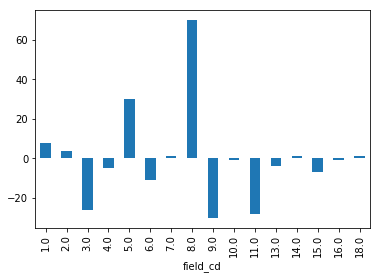

In [38]:
grouped_field_diff = df_field_male.groupby(['field_cd']).size() - df_field_fe.groupby(['field_cd']).size()
grouped_field_diff= grouped_field_diff.dropna()
grouped_field_diff.plot(kind= 'bar')

In [39]:
discrimination = dates.copy()

In [40]:
discrimination = discrimination.drop(['order', 'goal', 'date', 'age', 'go_out', 'age_diff', 'goal_equals', 'dec'], axis=1)
discrimination.head()

,gender,field_cd,imprace,imprelig,attr_o,race
0,0,1.0,2.0,4.0,40.0,4.0
1,0,1.0,2.0,4.0,41.0,4.0
2,0,1.0,2.0,4.0,42.0,4.0
3,0,1.0,2.0,4.0,42.0,4.0
4,0,1.0,2.0,4.0,37.0,4.0


In [41]:
discrimination.corr(method='spearman')

,gender,field_cd,imprace,imprelig,attr_o,race
gender,1.000000,-0.131806,-0.114166,-0.216292,0.006306,-0.034627
field_cd,-0.131806,1.000000,0.002359,-0.031903,-0.025317,0.034894
imprace,-0.114166,0.002359,1.000000,0.480305,-0.019158,-0.119712
imprelig,-0.216292,-0.031903,0.480305,1.000000,-0.014491,-0.098394
attr_o,0.006306,-0.025317,-0.019158,-0.014491,1.000000,-0.090925
race,-0.034627,0.034894,-0.119712,-0.098394,-0.090925,1.000000


In [42]:
cross = pd.crosstab(discrimination["field_cd"], discrimination["gender"])
print(cross)

gender      0     1
field_cd           
1.0       220   318
2.0        72   101
3.0       394   158
4.0       106    27
5.0       161   531
6.0       192    52
7.0        96    65
8.0       363  1267
9.0       413    65
10.0      439   467
11.0      404     0
12.0        0     9
13.0      318   280
14.0       53    59
15.0      128    29
16.0       13     1
17.0        0    10
18.0       12    16


###### Unisex decision tree
![title](unisex_decision_tree_sens.png)

###### Male decision tree
![title](male_decision_tree_sens.png)

###### Female decision tree
![title](female_decision_tree_sens.png)

Now, here is a colour-coded version of the unisex decision tree. Decisions that are more similar to the female model than they are to the male model have been coloured pink. Likewise, seemingly male-oriented decisions have been coloured blue. Decisions that are average between the male and female models were coloured orange, and finally, decisions that appear in neither the male, nor the female model have been left white.
![title](unisex_decision_tree_sens_coloured.png)

As you can see, the first step in the decision tree is a perfect average of the male and female models, which only makes sense. The decisions in the second level, however, are closer to those in the male model. The decisions in the female model are similar as well, but the values used in the unisex model are slightly closer to those that appear in the male model. Finally, we can see that in the third level, the decisions are clearly more similar to those in the female model. None of the decisions in this level look anything like those in the male model. This level also has one decision that has been coloured white, meaning it wasn't similar to either of the gender models.

But even though these decisions look like they come from the female model, we do not really know whether they hold for males as well.

To find out whether these decisions really are gender-oriented, we will take as example the bottom-right decision based on 'imprace <= 7.5'. If the female subjects are the only ones for whom this step in the decision tree has the approprate effect on their values of 'dec', then this will show that it is indeed a female-oriented decision. However, if the dec-values for males are affected similarly, then this would show that the model doesn't discriminate, and that this decision makes sense for both genders.

In [43]:
male_subjects0 = male_subjects.drop(male_subjects[male_subjects.attr_o <= 44.25].index)
male_subjects1 = male_subjects0.drop(male_subjects0[male_subjects0.imprace > 7.5].index)
male_subjects2 = male_subjects0.drop(male_subjects0[male_subjects0.imprace <= 7.5].index)

In [44]:
male_subjects11 = male_subjects1.drop(male_subjects1[male_subjects1.dec == 0].index)
male_subjects12 = male_subjects1.drop(male_subjects1[male_subjects1.dec == 1].index)
print("Male percentage dec=1 where imprace=<7.5 : " + str(len(male_subjects11) / (len(male_subjects12) + len(male_subjects11))))

Male percentage dec=1 where imprace=<7.5 : 0.7869415807560137


In [45]:
male_subjects21 = male_subjects2.drop(male_subjects2[male_subjects2.dec == 0].index)
male_subjects22 = male_subjects2.drop(male_subjects2[male_subjects2.dec == 1].index)
print("Male percentage dec=1 where imprace>7.5: " + str(len(male_subjects21) / (len(male_subjects22) + len(male_subjects21))))

Male percentage dec=1 where imprace>7.5: 0.5555555555555556


In [46]:
female_subjects0 = female_subjects.drop(female_subjects[female_subjects.attr_o <= 44.25].index)
female_subjects1 = female_subjects0.drop(female_subjects0[female_subjects0.imprace > 7.5].index)
female_subjects2 = female_subjects0.drop(female_subjects0[female_subjects0.imprace <= 7.5].index)

In [47]:
female_subjects11 = female_subjects1.drop(female_subjects1[female_subjects1.dec == 0].index)
female_subjects12 = female_subjects1.drop(female_subjects1[female_subjects1.dec == 1].index)
print("Female percentage dec=1 where imprace=<7.5 : " + str(len(female_subjects11) / (len(female_subjects12) + len(female_subjects11))))

Female percentage dec=1 where imprace=<7.5 : 0.7197452229299363


In [48]:
female_subjects21 = female_subjects2.drop(female_subjects2[female_subjects2.dec == 0].index)
female_subjects22 = female_subjects2.drop(female_subjects2[female_subjects2.dec == 1].index)
print("Female percentage dec=1 where imprace>7.5: " + str(len(female_subjects21) / (len(female_subjects22) + len(female_subjects21))))

Female percentage dec=1 where imprace>7.5: 0.5413533834586466


As these numbers show, it is not only the female decisions that have an increased chance when imprace <= 7.5. In fact, for males the increase in positive decisions is even greater (from 56% to 79%, instead of 54% to 72%). This shows that the decision is not female-oriented, and thus that the model doesn't discriminate.

Another path that is worth to look at in the female decision tree, is the bottom left part. In the female model the path where attr_0 <= 31.5 and imprelig > 2.5, has a leaf that is almost pure. In other words, females that don't rate their partner very high and that it's quite important that the partner is of the same religious background, the decision leads to not see the partner again. Because the split is on imprelig > 2.5, it is hard to imply anything about whether females want a partner of the same background. This is because larger than 2.5 is not a very exreme value. However, when looking at the male model, the split is made on imprace <= 4.5. When imprace > 4.5, the majority of the male subjects expresses their wish to not see their partner again. Looking at the third model, the unisex model, one can see that the split in the left bottom path is based on imprelig <= 3.5, where a value of imprelig > 3.5 gives a quite pure leaf containing the majority where dec = 0. In other words, in the unisex model the split is made on a larger imprelig value compared to the female model, and on a completely other attribute compared to the split of the male model. The unisex model could be discriminate on females in this particular split. However, if the dec-values for males are affected similarly, then this would show that the model doesn't discriminate, and that this decision makes sense for both genders. For both male and female models, the correlation between gender and the attribute imprelig are computed.  

In [49]:
male_subjects0_2 = male_subjects.drop(male_subjects[male_subjects.attr_o > 34.5].index)
male_subjects1_2 = male_subjects0_2.drop(male_subjects0_2[male_subjects0_2.imprelig > 3.5].index)
male_subjects2_2 = male_subjects0_2.drop(male_subjects0_2[male_subjects0_2.imprelig <= 3.5].index)

In [50]:
male_subjects1_21 = male_subjects1_2.drop(male_subjects1_2[male_subjects1_2.dec == 0].index)
male_subjects1_22 = male_subjects1_2.drop(male_subjects1_2[male_subjects1_2.dec == 1].index)
print("Male percentage dec=1 where imprelig <= 3.5 : " + str(len(male_subjects1_21) / (len(male_subjects1_22) + len(male_subjects1_21))))

Male percentage dec=1 where imprelig <= 3.5 : 0.23157894736842105


In [51]:
male_subjects2_21 = male_subjects2_2.drop(male_subjects2_2[male_subjects2_2.dec == 0].index)
male_subjects2_22 = male_subjects2_2.drop(male_subjects2_2[male_subjects2_2.dec == 1].index)
print("Male percentage dec=1 where imprelig >3.5: " + str(len(male_subjects2_21) / (len(male_subjects2_22) + len(male_subjects2_21))))

Male percentage dec=1 where imprelig >3.5: 0.11


In [52]:
female_subjects0_2 = female_subjects.drop(female_subjects[female_subjects.attr_o > 34.5].index)
female_subjects1_2 = female_subjects0_2.drop(female_subjects0_2[female_subjects0_2.imprelig > 3.5].index)
female_subjects2_2 = female_subjects0_2.drop(female_subjects0_2[female_subjects0_2.imprelig <= 3.5].index)

In [53]:
female_subjects1_21 = female_subjects1_2.drop(female_subjects1_2[female_subjects1_2.dec == 0].index)
female_subjects1_22 = female_subjects1_2.drop(female_subjects1_2[female_subjects1_2.dec == 1].index)
print("Female percentage dec=1 where imprelig <= 3.5 : " + str(len(female_subjects1_21) / (len(female_subjects1_22) + len(female_subjects1_21))))

Female percentage dec=1 where imprelig <= 3.5 : 0.1837160751565762


In [54]:
female_subjects2_21 = female_subjects2_2.drop(female_subjects2_2[female_subjects2_2.dec == 0].index)
female_subjects2_22 = female_subjects2_2.drop(female_subjects2_2[female_subjects2_2.dec == 1].index)
print("Female percentage dec=1 where imprelig > 3.5: " + str(len(female_subjects2_21) / (len(female_subjects2_22) + len(female_subjects2_21))))

Female percentage dec=1 where imprelig > 3.5: 0.04964539007092199


As these numbers show, it is not only the female decisions that have an increased chance when imprace <= 7.5.

What can be concluded from these numbers, is that when imprelig is strictly larger than 3.5 for females, the values of negative decisions decreases from 18% to 5%. For males, the percentage of positive decisions decreases from 23% to 11%. Thus, one could say that the unisex model is discriminating in this split, namely the model is significantly more appropriate for females. However, even though the split is most appropriate for females, this does not necessarily mean that the decision doesn't make sense for males at all. The percentage for males still more than halves, showing that the split is actually quite significant. Thus, the model doesn't truly discriminate against males here. 
However, data mining provides some powerfool tools for discovering discrimination in historical decision records. One of these is the classification rule mining. For classification rule mining, a potentially distriminated (PD) groups. A subset of attribute values are perceived as potentially discriminatory based on background knowledge. Potentially discriminated groups are people with those attribute values. This are the sensitive attributes that were chosen in the model at the beginning of this assignment. Direct discrimination occurs when decisions are made based on biased sensitive attributes. Associaton rules are if/ then statements that can help uncover relationships between, on first sight, unrelated data in a dataset. In a classification rule, $Y$ is a class item (in this case, `gender`) and $X$ contains no class items (in this case, the unisex model). This is denoted as follows: $X \rightarrow Y$. PD rules are any classification rule of the form: $A, B \rightarrow C$, where $A$ is the protected attribute (PD, the gender correlated attribute), $B$ is some context and $C$ is the attribute to predict (`dec`). It gets more complicated when you enter the area of indirect discrimination. Indirect discrimination occurs when decisions are made based on non-sensitive attributes which are strongly correlated with biased sensitive attributes. Potentially non-discriminatory (PND) rules may unveil discrimination, and are described as follows: $D,B \rightarrow C$, where $D$ is a PND group. For indirect discrimination, background knowledge is needed to allow us to infer discrimination in the model. Of course, this is all qualified what the confidence of these delivered rules are. The notion of extended lift is very important for measuing whether a group of people in a group are treated "less favorably" than others. Extended lift is a measture of the increased confidence in concluding an assertion $C$ resulting from adding (potentially discriminatory) information $A$ to a rule $B \rightarrow C$ where no PD itemset appears. Recall that `conf`($X \rightarrow Y$) = $\frac{`support`(X \rightarrow Y)}{`support`(X)}$So, let $A, B \rightarrow C$ be a classification rule with `conf`($B \rightarrow C$ > 0). The extended lift of the rule is: $$ elift(A,B \rightarrow C) = \frac{conf(A,B \rightarrow C)}{conf(B \rightarrow C)} $$. So, for example, a rule `gender = female`, `race <= 2.5` $\rightarrow$ `dec = 0` with an extended lift of 3 means that being a female increases 3 times the probability of deciding not to see the partner again with respect to the average confidence of people  who find it not important that their partner is of the same race. So when the extended lift, or this ratio, is very high, than you can claim that males or females are discriminated. So, you are trying to look for these rules where you have a increase in the confidence that is explainable only by the protected attributes that you were not supposed to see in the first place. The last thing that is important to know is the concept of $\alpha$-protection. For a given threshold $\alpha$, we say that PD rule $A,B \rightarrow C$, involving a PD group A in a contect B for an outcome C is $\alpha$-protective if:
                                $$elift_B (A,B \rightarrow C) = \frac{conf(A,B \rightarrow C}{conf(B \rightarrow C)} \leq \alpha$$
Otherwise, we say that $A,B \rightarrow C$ is an $\alpha$-discriminatory rule. 

In order to construct these association rules, we need to mine al itemsets (only with a minimum support) that contains both $A$ (`gender correlated attribute`) and $C$(`dec_predicted`), Apriori's algorithm is used to mine these rules.

In [55]:
df_apriori = dates.copy()
df_apriori.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,attr_o,race,age_diff,goal_equals,dec
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,40.0,4.0,6.0,False,1
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,41.0,4.0,1.0,False,1
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,42.0,4.0,1.0,True,1
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,42.0,4.0,2.0,True,1
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,37.0,4.0,3.0,False,1


In [56]:
apriori_set = df_apriori.values.tolist()
apriori_set

[[0, 4, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 40.0, 4.0, 6.0, False, 1],
 [0, 3, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 41.0, 4.0, 1.0, False, 1],
 [0, 10, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 42.0, 4.0, 1.0, True, 1],
 [0, 5, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 42.0, 4.0, 2.0, True, 1],
 [0, 7, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 37.0, 4.0, 3.0, False, 1],
 [0, 6, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 34.0, 4.0, 4.0, False, 0],
 [0, 1, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 37.0, 4.0, 9.0, False, 1],
 [0, 2, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 37.0, 4.0, 6.0, False, 0],
 [0, 8, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 46.0, 4.0, 7.0, False, 1],
 [0, 9, 2.0, 1.0, 7.0, 21.0, 1.0, 2.0, 4.0, 43.0, 4.0, 3.0, False, 1],
 [0, 10, 1.0, 1.0, 5.0, 24.0, 1.0, 2.0, 5.0, 33.0, 2.0, 3.0, True, 0],
 [0, 9, 1.0, 1.0, 5.0, 24.0, 1.0, 2.0, 5.0, 40.0, 2.0, 2.0, True, 0],
 [0, 6, 1.0, 1.0, 5.0, 24.0, 1.0, 2.0, 5.0, 35.0, 2.0, 2.0, False, 0],
 [0, 1, 1.0, 1.0, 5.0, 24.0, 1.0, 2.0, 5.0, 41.0, 2.0, 1.0, False, 1],
 [0, 3, 

In [57]:
def createC1(dataSet):
    C1 = []
    for transaction in dataSet:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
                
    C1.sort()
    return list(map(frozenset, C1))#use frozen set so we
                            #can use it as a key in a dict    

In [58]:
def scanD(D, Ck, minSupport):
    ssCnt = {}
    for tid in D:
        for can in Ck:
            if can.issubset(tid):
                if not can in ssCnt: ssCnt[can]=1
                else: ssCnt[can] += 1
    numItems = float(len(D))
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[key]/numItems
        if support >= minSupport:
            retList.insert(0,key)
        supportData[key] = support
    return retList, supportData

In [59]:
C1 = createC1(apriori_set)
C1

[frozenset({0}),
 frozenset({1.0}),
 frozenset({2.0}),
 frozenset({3}),
 frozenset({4}),
 frozenset({5}),
 frozenset({6.0}),
 frozenset({7.0}),
 frozenset({8}),
 frozenset({9.0}),
 frozenset({10}),
 frozenset({11}),
 frozenset({12}),
 frozenset({13.0}),
 frozenset({13.5}),
 frozenset({14}),
 frozenset({15}),
 frozenset({16}),
 frozenset({17}),
 frozenset({18.0}),
 frozenset({19.0}),
 frozenset({20.0}),
 frozenset({21.0}),
 frozenset({22.0}),
 frozenset({23.0}),
 frozenset({24.0}),
 frozenset({25.0}),
 frozenset({26.0}),
 frozenset({27.0}),
 frozenset({28.0}),
 frozenset({28.5}),
 frozenset({29.0}),
 frozenset({30.0}),
 frozenset({31.0}),
 frozenset({32.0}),
 frozenset({33.0}),
 frozenset({34.0}),
 frozenset({35.0}),
 frozenset({35.5}),
 frozenset({36.0}),
 frozenset({37.0}),
 frozenset({38.0}),
 frozenset({39.0}),
 frozenset({40.0}),
 frozenset({41.0}),
 frozenset({42.0}),
 frozenset({43.0}),
 frozenset({43.5}),
 frozenset({44.0}),
 frozenset({44.5}),
 frozenset({45.0}),
 frozenset({45

In [60]:
D = list(map(set,apriori_set))
D

[{0, 1.0, 2.0, 4, 6.0, 7.0, 21.0, 40.0},
 {0, 1.0, 2.0, 3, 4.0, 7.0, 21.0, 41.0},
 {0, 1.0, 2.0, 4.0, 7.0, 10, 21.0, 42.0},
 {0, 1.0, 2.0, 4.0, 5, 7.0, 21.0, 42.0},
 {0, 1.0, 2.0, 3.0, 4.0, 7, 21.0, 37.0},
 {0, 1.0, 2.0, 4.0, 6, 7.0, 21.0, 34.0},
 {0, 1, 2.0, 4.0, 7.0, 9.0, 21.0, 37.0},
 {0, 1.0, 2, 4.0, 6.0, 7.0, 21.0, 37.0},
 {0, 1.0, 2.0, 4.0, 7.0, 8, 21.0, 46.0},
 {0, 1.0, 2.0, 3.0, 4.0, 7.0, 9, 21.0, 43.0},
 {0, 1.0, 2.0, 3.0, 5.0, 10, 24.0, 33.0},
 {0, 1.0, 2.0, 5.0, 9, 24.0, 40.0},
 {0, 1.0, 2.0, 5.0, 6, 24.0, 35.0},
 {0, 1, 2.0, 5.0, 24.0, 41.0},
 {0, 1.0, 2.0, 3, 5.0, 24.0, 45.0},
 {0, 1.0, 2, 5.0, 24.0, 34.0},
 {0, 1.0, 2.0, 5.0, 6.0, 7, 24.0, 43.0},
 {0, 1.0, 2.0, 3.0, 5.0, 8, 24.0, 39.0},
 {0, 1.0, 2.0, 4, 5.0, 24.0, 39.0},
 {0, 1.0, 2.0, 5, 24.0, 45.0},
 {0, 1.0, 2.0, 3.0, 4.0, 6, 8.0, 25.0, 50.0},
 {0, 1.0, 2.0, 3.0, 4.0, 5, 6.0, 8.0, 25.0, 49.0},
 {0, 1.0, 2, 3.0, 4.0, 6.0, 8.0, 25.0, 48.0},
 {0, 1.0, 2.0, 3.0, 4.0, 6.0, 7, 8.0, 25.0, 48.0},
 {0, 1.0, 2.0, 3.0, 4.0, 6.0,

In [61]:
L1,suppDat0 = scanD(D,C1,0.5)
L1

[frozenset({5}),
 frozenset({3}),
 frozenset({6.0}),
 frozenset({4}),
 frozenset({2.0}),
 frozenset({1.0}),
 frozenset({0})]

In [62]:
def aprioriGen(Lk, k): #creates Ck
    retList = []
    lenLk = len(Lk)
    for i in range(lenLk):
        for j in range(i+1, lenLk): 
            L1 = list(Lk[i])[:k-2]; L2 = list(Lk[j])[:k-2]
            L1.sort(); L2.sort()
            if L1==L2: #if first k-2 elements are equal
                retList.append(Lk[i] | Lk[j]) #set union
    return retList

In [63]:
def apriori(dataSet, minSupport = 0.5):
    C1 = createC1(dataSet)
    D = list(map(set, dataSet))
    L1, supportData = scanD(D, C1, minSupport)
    L = [L1]
    k = 2
    while (len(L[k-2]) > 0):
        Ck = aprioriGen(L[k-2], k)
        Lk, supK = scanD(D, Ck, minSupport)#scan DB to get Lk
        supportData.update(supK)
        L.append(Lk)
        k += 1
    return L, supportData

In [64]:
L,suppData = apriori(apriori_set)
L

[[frozenset({5}),
  frozenset({3}),
  frozenset({6.0}),
  frozenset({4}),
  frozenset({2.0}),
  frozenset({1.0}),
  frozenset({0})],
 [frozenset({0, 3}),
  frozenset({1.0, 3}),
  frozenset({2.0, 3}),
  frozenset({0, 1.0}),
  frozenset({0, 2.0}),
  frozenset({1.0, 2.0}),
  frozenset({0, 4}),
  frozenset({1.0, 4}),
  frozenset({2.0, 4})],
 [frozenset({1.0, 2.0, 3}),
  frozenset({0, 2.0, 3}),
  frozenset({0, 1.0, 3}),
  frozenset({1.0, 2.0, 4}),
  frozenset({0, 2.0, 4}),
  frozenset({0, 1.0, 4}),
  frozenset({0, 1.0, 2.0})],
 [frozenset({0, 1.0, 2.0, 3}), frozenset({0, 1.0, 2.0, 4})],
 []]

In [65]:
aprioriGen(L[0],2)

[frozenset({3, 5}),
 frozenset({5, 6.0}),
 frozenset({4, 5}),
 frozenset({2.0, 5}),
 frozenset({1.0, 5}),
 frozenset({0, 5}),
 frozenset({3, 6.0}),
 frozenset({3, 4}),
 frozenset({2.0, 3}),
 frozenset({1.0, 3}),
 frozenset({0, 3}),
 frozenset({4, 6.0}),
 frozenset({2.0, 6.0}),
 frozenset({1.0, 6.0}),
 frozenset({0, 6.0}),
 frozenset({2.0, 4}),
 frozenset({1.0, 4}),
 frozenset({0, 4}),
 frozenset({1.0, 2.0}),
 frozenset({0, 2.0}),
 frozenset({0, 1.0})]

In [66]:
def generateRules(L, supportData, minConf=0.7):  #supportData is a dict coming from scanD
    bigRuleList = []
    for i in range(1, len(L)):#only get the sets with two or more items
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            if (i > 1):
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf)
            else:
                calcConf(freqSet, H1, supportData, bigRuleList, minConf)
    return bigRuleList 

In [67]:
def calcConf(freqSet, H, supportData, brl, minConf=0.7):
    prunedH = [] #create new list to return
    for conseq in H:
        conf = supportData[freqSet]/supportData[freqSet-conseq] #calc confidence
        if conf >= minConf: 
            print (freqSet-conseq,'-->',conseq,'conf:',conf)
            brl.append((freqSet-conseq, conseq, conf))
            prunedH.append(conseq)
    return prunedH

In [68]:
def rulesFromConseq(freqSet, H, supportData, brl, minConf=0.7):
    m = len(H[0])
    if (len(freqSet) > (m + 1)): #try further merging
        Hmp1 = aprioriGen(H, m+1)#create Hm+1 new candidates
        Hmp1 = calcConf(freqSet, Hmp1, supportData, brl, minConf)
        if (len(Hmp1) > 1):    #need at least two sets to merge
            rulesFromConseq(freqSet, Hmp1, supportData, brl, minConf)

In [69]:
L,suppData= apriori(apriori_set,minSupport=0.5)

In [70]:
rules= generateRules(L,suppData, minConf=0.7)

frozenset({3}) --> frozenset({0}) conf: 0.9317781690140844
frozenset({3}) --> frozenset({1.0}) conf: 0.9643485915492958
frozenset({3}) --> frozenset({2.0}) conf: 0.8930457746478874
frozenset({1.0}) --> frozenset({0}) conf: 0.9291767554479419
frozenset({0}) --> frozenset({1.0}) conf: 0.963741955736933
frozenset({2.0}) --> frozenset({0}) conf: 0.9317851959361394
frozenset({0}) --> frozenset({2.0}) conf: 0.9069219902684037
frozenset({2.0}) --> frozenset({1.0}) conf: 0.964038058377681
frozenset({1.0}) --> frozenset({2.0}) conf: 0.9046610169491525
frozenset({4}) --> frozenset({0}) conf: 0.9351290684624017
frozenset({4}) --> frozenset({1.0}) conf: 0.9656565656565655
frozenset({4}) --> frozenset({2.0}) conf: 0.8812570145903478
frozenset({3}) --> frozenset({1.0, 2.0}) conf: 0.8576144366197183
frozenset({3}) --> frozenset({0, 2.0}) conf: 0.833406690140845
frozenset({3}) --> frozenset({0, 1.0}) conf: 0.8961267605633804
frozenset({4}) --> frozenset({1.0, 2.0}) conf: 0.8487093153759819
frozenset({

In [71]:
df_apriori2 = dates.copy()
df_apriori2.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,attr_o,race,age_diff,goal_equals,dec
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,40.0,4.0,6.0,False,1
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,41.0,4.0,1.0,False,1
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,42.0,4.0,1.0,True,1
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,42.0,4.0,2.0,True,1
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,37.0,4.0,3.0,False,1


In [72]:
import pandas as pd
from mlxtend.preprocessing import OnehotTransactions
from mlxtend.frequent_patterns import apriori

In [77]:
frequent_itemsets = apriori(df_apriori2, min_support=0.2, use_colnames=True)

In [78]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.505191,[gender],1
1,8.84062,[order],1
2,2.09256,[goal],1
3,7.70171,[field_cd],1
4,4.97427,[date],1
5,26.2499,[age],1
6,2.12604,[go_out],1
7,3.83316,[imprace],1
8,3.62114,[imprelig],1
9,39.3253,[attr_o],1


In [80]:
frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.2) ]

,support,itemsets,length
14,0.409563,"[gender, goal]",2
15,0.313789,"[gender, go_out]",2
16,0.2534,"[gender, imprace]",2
17,0.304138,"[gender, imprelig]",2
18,0.279281,"[gender, race]",2
19,0.249159,"[gender, dec]",2
20,0.413218,"[goal, goal_equals]",2
21,0.378857,"[goal, dec]",2
22,0.34391,"[go_out, goal_equals]",2
23,0.346981,"[go_out, dec]",2


### 2.2 Biclustering